<a href="https://colab.research.google.com/github/richsharples/MIT-DS/blob/main/Reference_Notebook_Milestone_2_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Milestone 2**

In [30]:
# Downgrading statsmodels as per Great Learning advice
!pip install statsmodels==0.12.1

# Version check 
import statsmodels
statsmodels.__version__

'0.12.1'

### **Natural gas based CO2 emission forecasting**

In [31]:
#Import basic libraries
import pandas as pd
import warnings
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

For developing the time series model and forecasting, you are expected to use the natural gas CO2 emission from the electrical power generation. We need to slice this data:

In [32]:
# Read the data

from google.colab import drive
drive.mount('/content/drive')

dfname = '/content/drive/MyDrive/MIT-DataServices/Notebooks/Capstone/MER_T12_06.xlsx'

dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')

#We're only interested in the first 3 columns - YYYYMM, MSN, Value
df = pd.read_excel(dfname, 
                parse_dates=['YYYYMM'],
                index_col='YYYYMM', 
                date_parser=dateparse)

df.head() 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,MSN,Value,Description
YYYYMM,,,
1973-01-01,CLEIEUS,72.076,Coal Electric Power Sector CO2 Emissions
1973-02-01,CLEIEUS,64.442,Coal Electric Power Sector CO2 Emissions
1973-03-01,CLEIEUS,64.084,Coal Electric Power Sector CO2 Emissions
1973-04-01,CLEIEUS,60.842,Coal Electric Power Sector CO2 Emissions
1973-05-01,CLEIEUS,61.798,Coal Electric Power Sector CO2 Emissions


In [33]:
###Slice the data to get the monthly total CO2 emissions of Natural Gas Electric Power Sector
 
Emissions = df.iloc[:,1:]   # Monthly total emissions (mte)
Emissions= Emissions.groupby(['Description', pd.Grouper(freq='M')])['Value'].sum().unstack(level = 0)
mte = Emissions['Natural Gas Electric Power Sector CO2 Emissions'] # monthly total emissions (mte)

#convert the emision value into numeric value
 
mte = pd.to_numeric(mte,errors = 'coerce')

print ("MTE",mte)

MTE YYYYMM
1973-01-31    12.175
1973-02-28    11.708
1973-03-31    13.994
1973-04-30    14.627
1973-05-31    17.344
               ...  
2016-03-31    40.525
2016-04-30    39.763
2016-05-31    44.210
2016-06-30    53.567
2016-07-31    62.881
Name: Natural Gas Electric Power Sector CO2 Emissions, Length: 523, dtype: float64


In [34]:
 #Check 1st few rows of data

print (mte.count())
print (mte.head())
print (mte.tail())

523
YYYYMM
1973-01-31    12.175
1973-02-28    11.708
1973-03-31    13.994
1973-04-30    14.627
1973-05-31    17.344
Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64
YYYYMM
2016-03-31    40.525
2016-04-30    39.763
2016-05-31    44.210
2016-06-30    53.567
2016-07-31    62.881
Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64


###**Split the dataset**

In [35]:
# Split the data into train and test
# Train : 70% of 523 = 366
# Test = 157

mte_train = mte.iloc[0:366]
mte_test = mte.iloc[366:523]

print ("Train")
print (mte_train.count())
print ( mte_train.head())
print ( mte_train.tail())

print ("Test")
print (mte_test.count())
print ( mte_test.head())
print ( mte_test.tail())

Train
366
YYYYMM
1973-01-31    12.175
1973-02-28    11.708
1973-03-31    13.994
1973-04-30    14.627
1973-05-31    17.344
Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64
YYYYMM
2003-02-28    18.157
2003-03-31    19.593
2003-04-30    19.097
2003-05-31    21.338
2003-06-30    23.597
Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64
Test
157
YYYYMM
2003-07-31    34.140
2003-08-31    37.020
2003-09-30    25.382
2003-10-31    22.150
2003-11-30    18.858
Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64
YYYYMM
2016-03-31    40.525
2016-04-30    39.763
2016-05-31    44.210
2016-06-30    53.567
2016-07-31    62.881
Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64


###**Test the Stationarity**

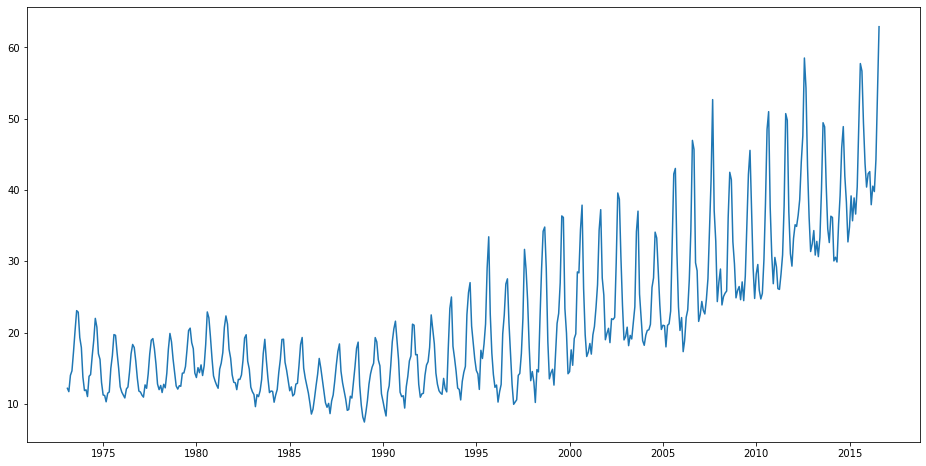

In [36]:
#Import the required package

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

plt.figure(figsize=(16,8))
plt.plot(mte)


###**Test the stationarity through Visualization**

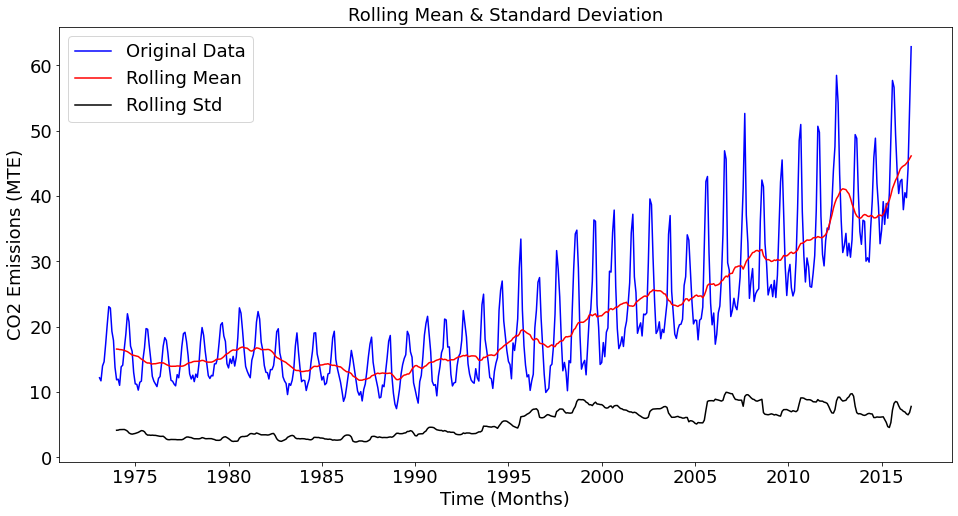

In [37]:
from IPython.core.pylabtools import figsize

# Function to visualize the rolling mean and standard deviation
#   ts : data
#   win : size of the moving window

def TestStationaryPlot(ts, win):

    FSZ = 18
    rol_mean = ts.rolling(window = win, center = False).mean()
    rol_std = ts.rolling(window = win, center = False).std()
    
    plt.figure(figsize=(16,8))

    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = FSZ)
    plt.yticks(fontsize = FSZ)
    
    plt.xlabel('Time (Months)', fontsize = FSZ)
    plt.ylabel('CO2 Emissions (MTE)', fontsize = FSZ)
    plt.legend(loc='best', fontsize = FSZ)
    plt.title('Rolling Mean & Standard Deviation', fontsize = FSZ)
    plt.show()


# Calculate the rolling mean and standard deviation for a window over 12 observations

TestStationaryPlot(mte,12)


**Observations and Insights: **

There is an obvious upward trend in the Rolling Mean and the Standard Deviation varies slightly over time. The series is not stationary.


### **Test the stationarity using the Augmented Dickey-Fuller Test**


Use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not. The null and alternate hypotheses for the ADF Test are defined as:

**- Null hypothesis:** The Time Series is non-stationary


**- Alternative hypothesis:** The Time Series is stationary

In [38]:
#Define a function to use adfuller test

#Importing adfuller using statsmodels
from statsmodels.tsa.stattools import adfuller

def TestStationarityADF(df_train):
  pv_threshold = 0.05

  print('Dickey-Fuller test results ')
  adftest = adfuller(df_train)
  pv = adftest[1]
  print('ADF Statistic: \t%4f' % adftest[0])
  print('p-value: \t%4f' % pv)  
  print ("Critical Values")
  for key,value in adftest[4].items():
	  print('\t%s: %.3f' % (key, value))
   
# p-value > pv_threshold: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= pv_threshold: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

  if (pv > pv_threshold):
    print ("series is non-stationary")
  else:
    print ("series is stationary")
    
TestStationarityADF(mte)

Dickey-Fuller test results 
ADF Statistic: 	1.831215
p-value: 	0.998409
Critical Values
	1%: -3.443
	5%: -2.867
	10%: -2.570
series is non-stationary


- **Observations and Insights**

From the above test, we can see that the p-value = 0.99 i.e. > 0.05 (For 95% confidence intervals) therefore, we fail to reject the null hypothesis.
Hence, we can confirm that the series is non-stationary.

###**Transformation of the dataset into a stationary one**

**We can use some of the following methods to convert a non-stationary series into a stationary one:**


1. Log Transformation
2. Differencing the series (lagged series)

We take the average of ‘k’ consecutive values depending on the frequency of time series (in this capstone 12 months). 

Here, we will take the average over the past 1 year.

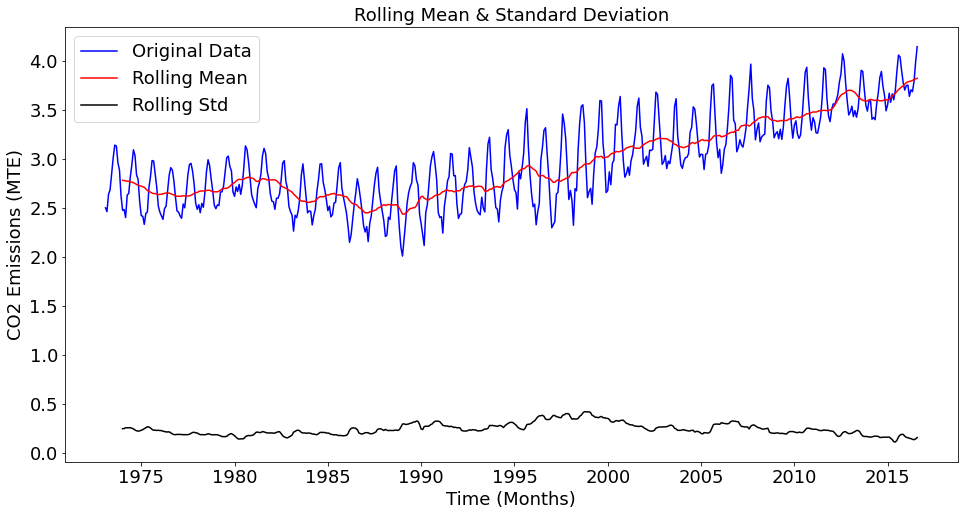

Dickey-Fuller test results 
ADF Statistic: 	0.553272
p-value: 	0.986405
Critical Values
	1%: -3.443
	5%: -2.867
	10%: -2.570
series is non-stationary


In [39]:
# Visualize the rolling mean and standard deviation after using log transformation

mte_log = np.log(mte)

TestStationaryPlot(mte_log,12)

# Confirm with ADF
TestStationarityADF(mte_log)


**Observations and Insights: **

After the log transformation, there is still an obvious upward trend in the Rolling Mean The Standard Deviation has improved but is not constant. The series is still not stationary.

Because the rolling window is 12 months the rolling mean and std dev is missing for the first 11 values.

**Visualize the rolling mean and rolling standard deviation of the shifted series (df_shift) and check the stationarity by calling the adfuller() function. Also, write your observations on the same.**

####**Think about it:**

- Do you need to remove the null values that we get after applying differencing method?

Yes - otherwise Dicky Full Test blows up

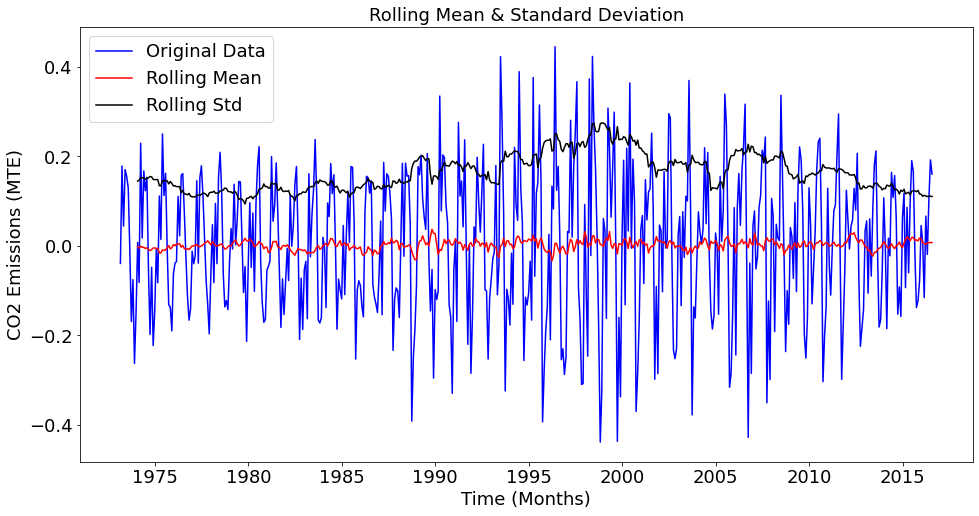

In [40]:
# Apply first-order differencing to the log transformed time series
# to remove trend and seasonality

mte_shift = mte_log - mte_log.shift(1)

mte_shift.dropna(inplace=True)

TestStationaryPlot (mte_shift,12)

**Observations and Insights: **

First-order differencing has effectively removed the trend but seasonality is still evident.

Rolling mean is now constant so it is now stationary.

In [41]:
TestStationarityADF(mte_shift)

Dickey-Fuller test results 
ADF Statistic: 	-4.964797
p-value: 	0.000026
Critical Values
	1%: -3.443
	5%: -2.867
	10%: -2.570
series is stationary


**Observations and Insights: **

p_value is less than 0.5 so the series is stationary. ADF Statistic is less than Critical Values (1%, 5%, 10%) so we can say with confidence that the series is stationary.

### **Elimination of trend and seasonality: Decomposition**

Dickey-Fuller test results 
ADF Statistic: 	-8.547084
p-value: 	0.000000
Critical Values
	1%: -3.444
	5%: -2.867
	10%: -2.570
series is stationary


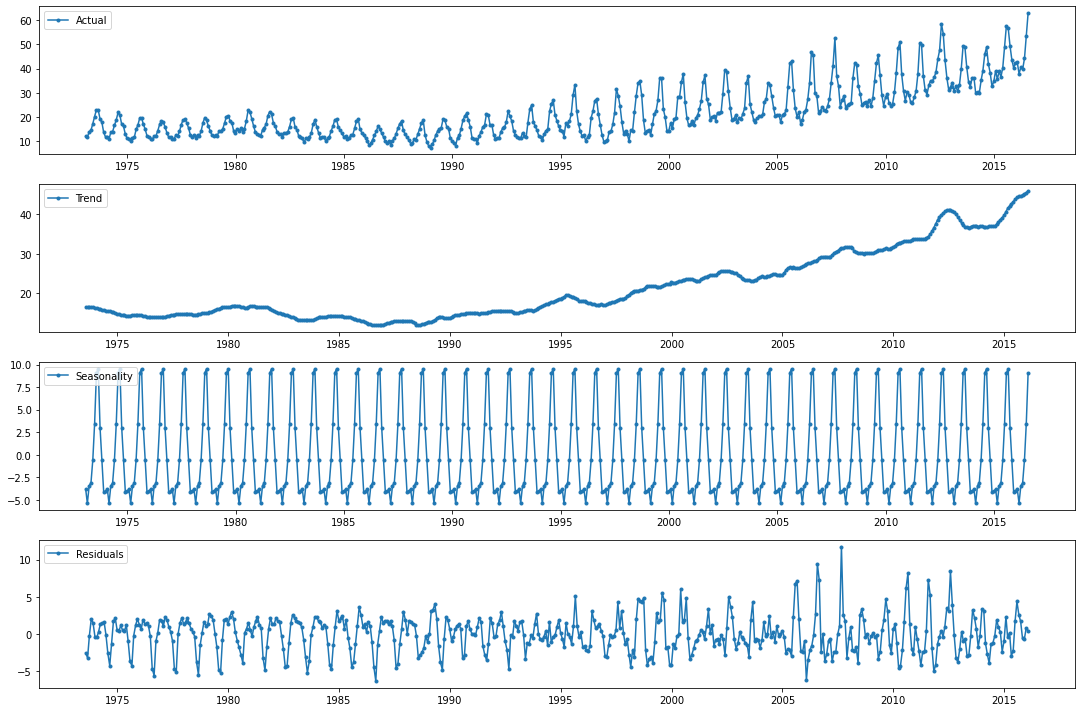

In [47]:
#Importing the seasonal_decompose function to decompose the time series
# decompose the orinal time series

from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(mte)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(mte, label='Actual', marker='.')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)

plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)

plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

In [50]:
# test residuals for stationarity

residual.dropna(inplace=True)
TestStationarityADF(residual)
residual.describe()

Dickey-Fuller test results 
ADF Statistic: 	-8.547084
p-value: 	0.000000
Critical Values
	1%: -3.444
	5%: -2.867
	10%: -2.570
series is stationary


count    511.000000
mean      -0.002326
std        2.476963
min       -6.325476
25%       -1.552014
50%        0.010896
75%        1.581284
max       11.745857
Name: resid, dtype: float64

**Observations and Insights: **

We can see that there are significant trend, seasonality and residuals components in the series.

The residuals are stationary - we could use residuals for further modelling.


**Plot the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models**

### **Find optimal parameters (P, Q) and build the AR, MA, ARMA & ARIMA models**

**Plot the ACF and PACF charts and find the optimal parameters**

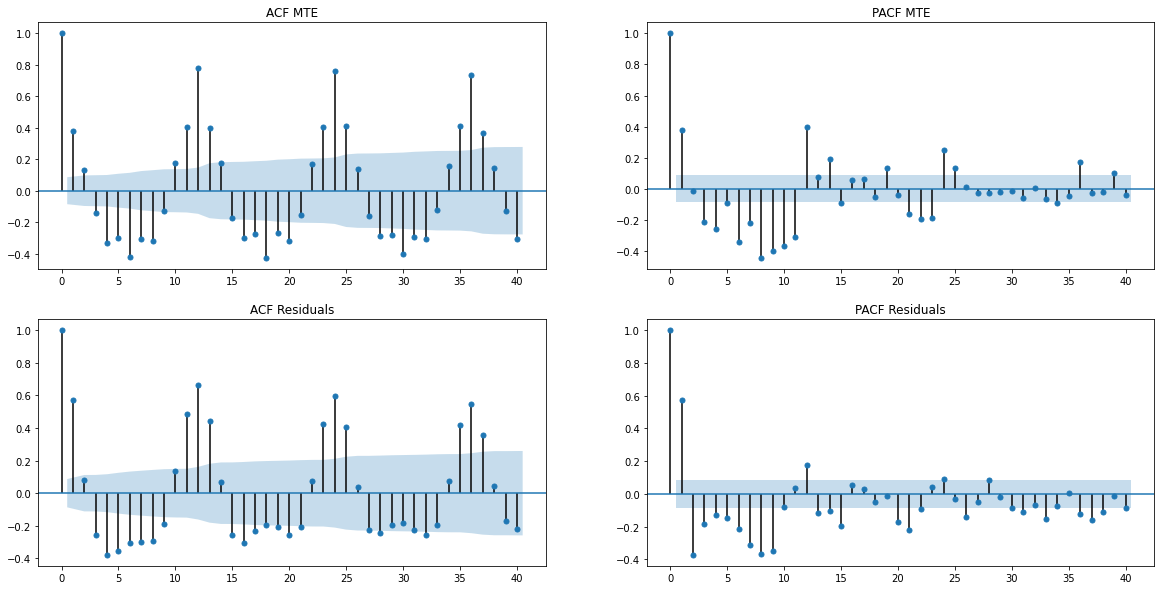

In [73]:

# Plot (P)ACF using log transformed and shifted data
# to find p & q

# also want to see how residuals compare

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

nlags = 40

fig, ax = plt.subplots(2,2,figsize=(20,10))
plot_acf(mte_shift.values.squeeze(), lags=nlags, ax=ax[0,0], title='ACF MTE')
plot_pacf(mte_shift.values.squeeze(), lags=nlags, ax=ax[0,1], title='PACF MTE')
plot_acf(residual.values.squeeze(), lags=nlags, ax=ax[1,0], title='ACF Residuals')
plot_pacf(residual.values.squeeze(), lags=nlags, ax=ax[1,1], title='PACF Residuals')
plt.show()



**Observations and Insights: **

From the above PACF plot we can see that the highest lags at which the plot extends beyond the statistically significant boundary are 1, 8, 9, and 12.
This indicates that an AR Model of lag (p) 1 8, 9, and 12 should be tested.
Similarly, from the ACF plot, we can infer that q=1 6, 11, 12 should be tested.

###**AR Model**

Order p is the lag value after which the PACF plot crosses the upper confidence interval for the first time. These p lags will act as our features while forecasting the AR time series.

Fit and predict the shifted series with the AR Model and calculate the RMSE. Also, visualize the time series and write your observations.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


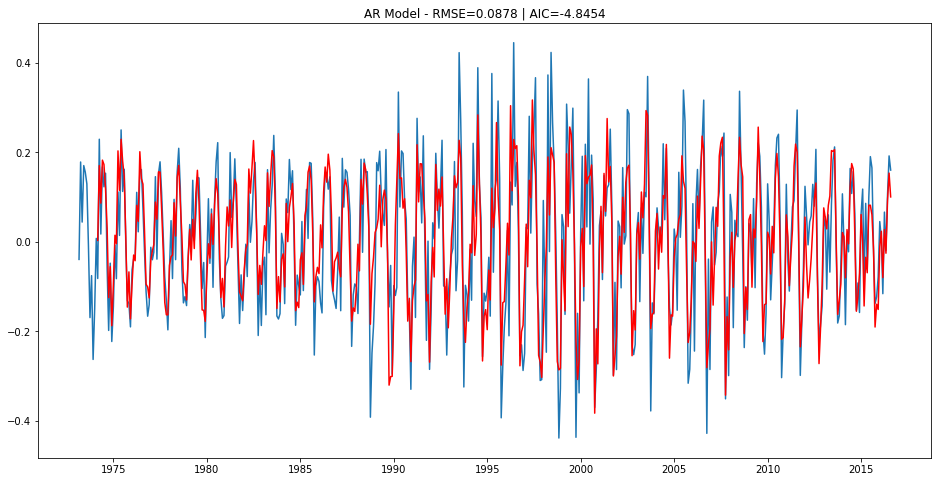

In [71]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

#To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

# cantidate lags 1, 8, 9, 12

plt.figure(figsize=(16,8))
model_AR = AutoReg(mte_shift,lags=12) 
results_AR = model_AR.fit() 
plt.plot(mte_shift)

predict = results_AR.predict() #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0

plt.plot(results_AR.predict(), color='red')

plt.title("AR Model - RMSE={mse:.4f} | AIC={aic:.4f}".format(
    mse=mean_squared_error(predict,mte_shift, squared=False), 
    aic=results_AR.aic))

plt.show()

**Observations & Insights: **

The AR Model is predicting the seasonality but is underestimeating the magnitude.

The best lag is 12, RMSE=0.088, AIC=-4.84

###**MA Model**

####**Think about it:**

- Do we really have to find AR & I value other than 0 to forecast on the MA based model?

Order q of the MA process is obtained from the ACF plot, this is the lag after which ACF crosses the upper confidence interval for the first time.

Fit and predict the shifted series with the MA Model and calculate the RMSE. Also, visualize the time series and write your observations.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


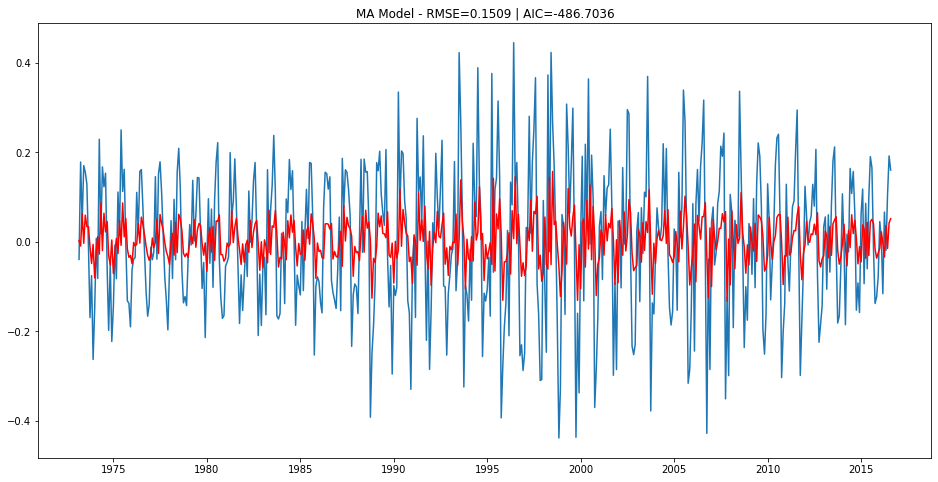

In [16]:
from statsmodels.tsa.arima.model import ARIMA

plt.figure(figsize=(16,8))

# candidates for q = 1,6,11,12. q=1 is the only value that converges
model_MA = ARIMA (mte_shift, order=(0, 0, 1))  #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_MA = model_MA.fit() #fit the model
plt.plot(mte_shift)
plt.plot(results_MA.predict(), color='red')

plt.title("MA Model - RMSE={mse:.4f} | AIC={aic:.4f}".format(
    mse=mean_squared_error(results_MA.fittedvalues,mte_shift, squared=False), 
    aic=results_MA.aic))

plt.show()

**Observations & Insights: **

The model is again tracking the seasonality but not the magnitude.

The RMSE is slightly worse at 0.1509 and the AIC is 486.7

###**ARMA MODEL**

**We will be using the above AR lag(P) & MA lag(Q) as a paramter** and d=0 in ARIMA so that it will work as an ARMA model.

Fit and predict the shifted series with the ARMA Model and calculate the RMSE. Also, visualize the time series and write your observations.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


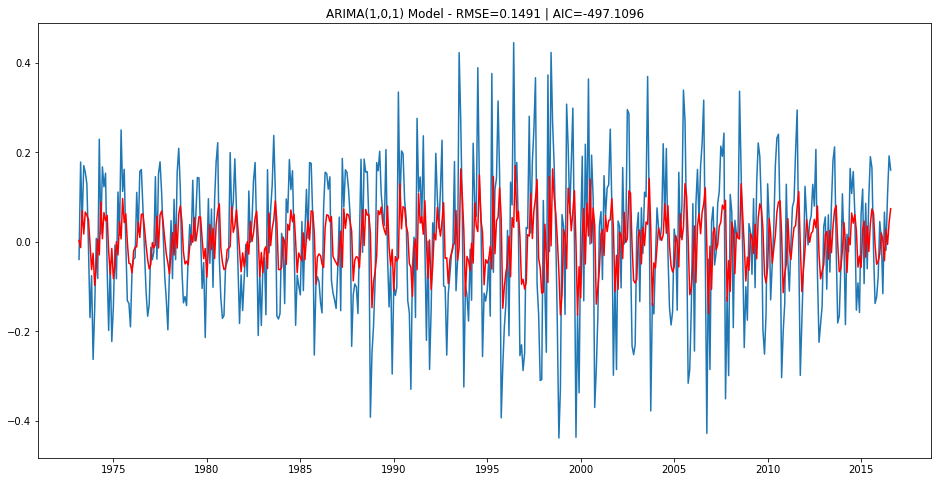

In [17]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA (mte_shift, order=(1, 0, 1)) #Using p=1, d=0, q=1 and apply ARIMA function on mte_shift series
results_ARMA = model_ARMA.fit( ) #fit the model
plt.plot(mte_shift)
plt.plot(results_ARMA.predict(), color='red')

plt.title("ARIMA(1,0,1) Model - RMSE={mse:.4f} | AIC={aic:.4f}".format(
    mse=mean_squared_error(results_ARMA.fittedvalues,mte_shift, squared=False), 
    aic=results_ARMA.aic))

plt.show()

**Observations & Insights: **

Thias model has the highest AIC so is a candidate for further investigation.

**Check the AIC value of the model**

In [18]:
print(f"AIC=%.2f"%results_ARMA.aic)


AIC=-497.11


###**ARIMA MODEL**

**Fit and predict the shifted series with the ARIMA Model and calculate the RMSE. Also, visualize the time series and write your observations.**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


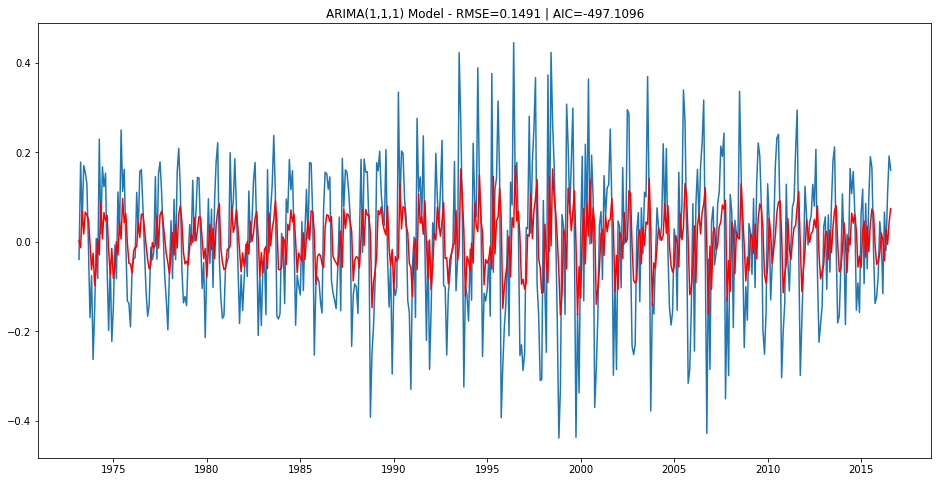

In [19]:
model_ARIMA = ARIMA(mte_shift, order=(1, 0, 1)) #Using p=1, d=1, q=1 and apply ARIMA function on mte_shift series
results_ARIMA = model_ARIMA.fit() #fit the model

plt.figure(figsize=(16,8))

plt.plot(mte_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')

plt.title("ARIMA(1,1,1) Model - RMSE={mse:.4f} | AIC={aic:.4f}".format(
    mse=mean_squared_error(results_ARIMA.fittedvalues,mte_shift, squared=False), 
    aic=results_ARIMA.aic))

plt.show()

**Check the AIC value of the model**

In [20]:
# Printing the fitted values from arima

results_ARIMA.fittedvalues

YYYYMM
1973-02-28    0.003263
1973-03-31   -0.012715
1973-04-30    0.070073
1973-05-31    0.017536
1973-06-30    0.066458
                ...   
2016-03-31   -0.041914
2016-04-30    0.028151
2016-05-31   -0.005667
2016-06-30    0.042461
2016-07-31    0.074183
Length: 522, dtype: float64

###**Inverse Transformation**

**Use the correct inverse transformation depending on the model chosen to get back the original values.**



**Apply an inverse transformation on the predictions of the chosen model**

In [21]:
#First step - doing cumulative sum

pred=pd.Series(results_ARIMA.fittedvalues)

pred_cumsum = pred.cumsum(axis='index')

#Second step - Adding the first value of the log series to the cumulative sum values

pred_log = pd.Series(mte_log[0], index=mte_log.index)

pred_log = pred_log.add(pred_cumsum, fill_value=0)

#Third step - applying exponential transformation

pred_ARIMA = np.exp (pred_log)

print (pred_ARIMA)

YYYYMM
1973-01-31    12.175000
1973-02-28    12.214791
1973-03-31    12.060463
1973-04-30    12.935890
1973-05-31    13.164733
                ...    
2016-03-31    53.708564
2016-04-30    55.241992
2016-05-31    54.929837
2016-06-30    57.312443
2016-07-31    61.725699
Length: 523, dtype: float64


**Plot the original vs predicted series**

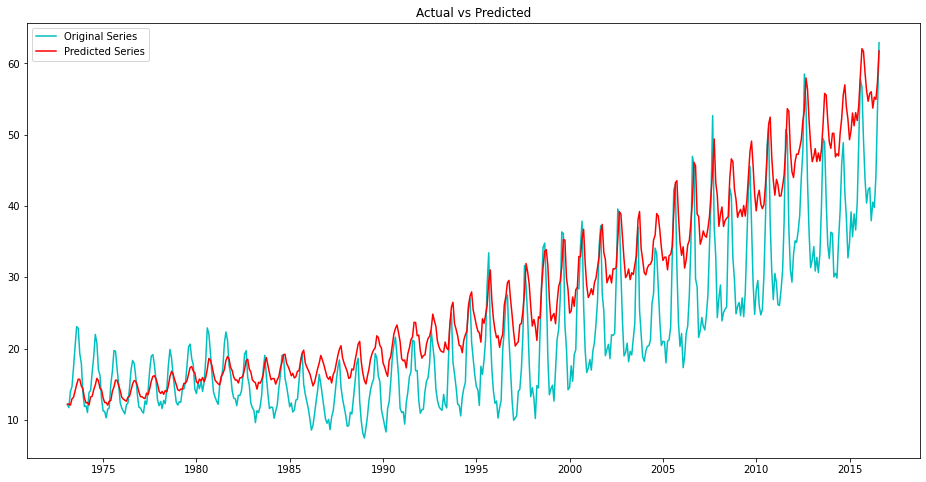

In [22]:
#Code here

plt.figure(figsize=(16,8))
plt.plot(mte, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(pred_ARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions_ARIMA 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations & Insights: **

The ARIMA (1,1,1) does a good job of tracking the trend but doesn't do well predicting the magnitude.

###**Forecast the values for next 24 months and compare it with test data**

In [23]:
#Add the code blocks based on the requirements

forecasted_ARIMA = results_ARIMA.forecast(steps=24)   #forecast using the results_ARIMA for next 24 months. Keep steps=24
forecasted_ARIMA

2016-08-31    0.061541
2016-09-30    0.024271
2016-10-31    0.010836
2016-11-30    0.005993
2016-12-31    0.004247
2017-01-31    0.003618
2017-02-28    0.003391
2017-03-31    0.003309
2017-04-30    0.003280
2017-05-31    0.003269
2017-06-30    0.003265
2017-07-31    0.003264
2017-08-31    0.003263
2017-09-30    0.003263
2017-10-31    0.003263
2017-11-30    0.003263
2017-12-31    0.003263
2018-01-31    0.003263
2018-02-28    0.003263
2018-03-31    0.003263
2018-04-30    0.003263
2018-05-31    0.003263
2018-06-30    0.003263
2018-07-31    0.003263
Freq: M, Name: predicted_mean, dtype: float64

###**Check the RMSE on the original train and test data and write your conclusion from the above analysis.**

In [76]:
from sklearn.metrics import mean_squared_error
error =  mean_squared_error (pred_ARIMA, mte) #calculate RMSE using the predictions_ARIMA and mte 
print ('RMSE Train / Predict : %.4f'% error)


RMSE Train / Predict : 67.2794


**Conclusion**

It is clear that manual tuning and testing of models is time-consuming and sub-optimal. The best model I have produced is not adequate so further refinement is required.

####**Think about it:**
- Can we use other than RMSE measurement to check the performance of the model?

Yes - AIC should be used as well.

####**Think about it:**

 Can we use other forecasting methods such as SARIMA to improve our model performance?

- [A Gentle Introduction to SARIMA for Time Series Forecasting in Python](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/)
- [Forecasting with Seasonal ARIMA in Python](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


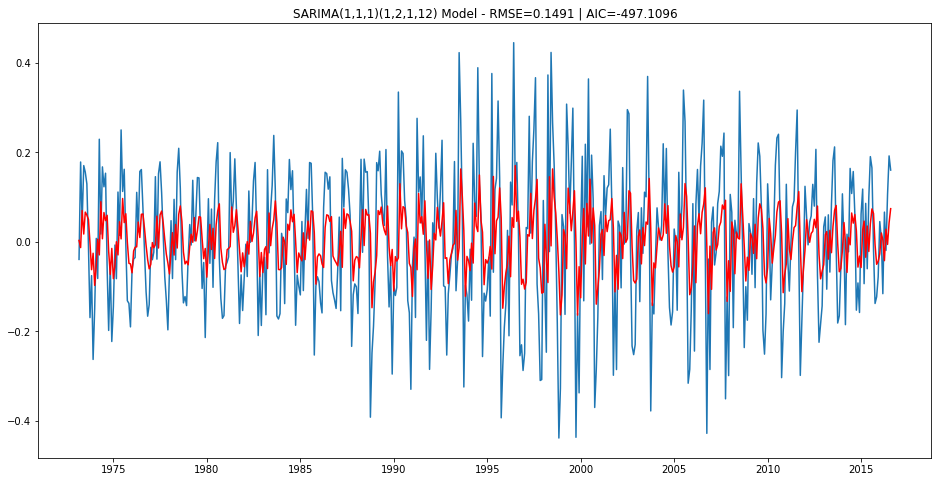

In [75]:
import statsmodels.api as sm

model_SARIMA=sm.tsa.statespace.SARIMAX(
      mte_shift,
      order=(1, 0, 1),
      seasonal_order=(0,1,1,12))
    
results_SARIMA = model_ARIMA.fit() #fit the model

plt.figure(figsize=(16,8))

plt.plot(mte_shift)
plt.plot(results_SARIMA.predict(), color='red')

plt.title("SARIMA(1,1,1)(1,2,1,12) Model - RMSE={mse:.4f} | AIC={aic:.4f}".format(
    mse=mean_squared_error(results_SARIMA.fittedvalues,mte_shift, squared=False), 
    aic=results_SARIMA.aic))

plt.show()


## **Proposed Approach**

See associated document.

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?